In [1]:
import datajoint as dj

In [2]:
dj.config['database.host'] = 'tutorial-db.datajoint.io'
dj.config['database.user'] = 'dimitri'

In [3]:
schema = dj.schema('catalog_alm1_dimitri', locals())

Connecting dimitri@tutorial-db.datajoint.io:3306


In [4]:
@schema
class Keyword(dj.Lookup):
    definition = """
    # Tag of study types
    keyword : varchar(24)  
    """
    contents = zip(['behavior', 'extracellular', 'photostim'])

@schema
class Study(dj.Manual):
    definition = """
    # Study 
    study : varchar(8)    # short name of the study
    --- 
    study_description : varchar(255)   #  
    institution : varchar(255)  # institution conducting the study
    lab : varchar(255)  #  lab conducting the study
    reference_atlas : varchar(255)   # e.g. "paxinos"
    """
    
@schema
class StudyKeyword(dj.Manual):
    definition = """
    # Study keyword (see general/notes)
    -> Study
    -> Keyword
    """

@schema
class Publication(dj.Manual):
    definition = """
    # Publication
    doi  : varchar(60)   # publication DOI
    ----
    full_citation : varchar(4000)
    authors='' : varchar(4000)
    title=''   : varchar(1024)
    """
    
@schema
class RelatedPublication(dj.Manual):
    definition = """
    -> Study
    -> Publication
    """

In [5]:
@schema
class Animal(dj.Manual):
    definition = """
    animal_id  : int   # Janelia institution mouse IDs  
    --- 
    species        : varchar(30)
    date_of_birth  : date   
    sex            : enum('M','F','Unknown')
    animal_source  : varchar(30)
    """

In [6]:
@schema
class Surgery(dj.Manual):
    definition = """
    -> Animal
    --- 
    surgery : varchar(4000)    # description of surgery
    """
    
@schema
class Virus(dj.Manual):
    definition = """
    -> Animal
    """
    
    class InfectionSite(dj.Part):
        definition = """
        -> Virus
        site : tinyint  # virus infection site
        ---
        infection_x : decimal(3,2)   # (mm)
        infection_y : decimal(3,2)   # (mm)
        infection_z : decimal(3,2)   # (mm)
        """
        
@schema
class BrainArea(dj.Lookup):
    definition = """
    brain_area : varchar(12)
    """
    contents = zip(['M2', 'V1'])

In [7]:
@schema
class Session(dj.Manual):
    definition = """
    -> Animal
    session  : int   # session within 
    --- 
    -> Study
    session_date       : date         # session date 
    session_suffix     : char(1)      # suffix for disambiguating sessions 
    experimenter       : varchar(60)  # experimenter's name
    session_start_time : datetime   
    raw_data_path      : varchar(255) # File path to raw data -- transform to external
    recording_type     : varchar(8)   # e.g. acute   
    """

In [8]:
@schema
class Optogenetics(dj.Manual):
    definition = """
    # Optogenetic stimulation information for the sesssion
    -> Session
    """
    
    class Site(dj.Part):
        definition = """
        # Optogenetic stimulation site
        -> Optogenetics
        site_number   : tinyint  #  optogenetic site number  
        ---
        description : varchar(255)   # optogenetic site description
        stimulation_method  : varchar(255)
        device   : varchar(60)
        location_x  : decimal(4,2)  # mm
        location_y  : decimal(4,2)  # mm
        excitation_lambda : decimal(4,1)  # nm 
        """

In [9]:

    
# 32-electrode NeuroNexus silicon probes recorded on a 
# PCI6133 National Instrimunts board. See 'general/experiment_description' 
# for more information

# The extracellular recording traces were band-pass filtered (300-6k Hz).  
# Events that exceeded an amplitude threshold (4 standard deviations of the background) 
# were subjected to manual spike sorting to extract clear single units [1].  
# Spike sorting was performed on data from individual recording sessions.  
# For each unit, its spike width was computed as the trough to peak interval in the mean 
# spike waveform.  We defined units with spike width <0.35 ms as fast-spiking GABAergic (FS) 
# neurons and units with spike width >0.45 ms as putative pyramidal neurons.  
# Units with intermediate values (0.35 - 0.45 ms, 39/133) were excluded from our analyses.  
# 73 neurons were antidromically activated by photostimulating the PT neuron axons.  
# 134 neurons were antidromically activated by photostimulating the IT neuron axons.  
# These neurons were further tested for collisions in which we looked for absence 
# of antidromic spikes when they were preceded by spontaneous spikes [4].  
# Neurons that passed the collision test were classified as PT neurons or IT neurons.  
# Neurons that failed the test were classified as PT-coupled neurons or IT-coupled neurons 
# because they were presumably synaptically-connected to ChR+ PT neurons and IT neurons.  
# Finally, a few cells could not be tested due to an absence of spontaneous activity and 
# these neurons were excluded from further analyses.  

# ----------
# References
# 1. Guo ZV, Li N, Huber D, Ophir E, Gutnisky  DA, et al. (2014) Flow of cortical activity underlying a tactile decision in mice. Neuron 81: 179-194.
# 2. O'Connor DH, Clack NG, Huber D, Komiyama T, Myers EW, et al. (2010) Vibrissa-based object localization in head-fixed mice. J Neurosci 30: 1947-1967.
# 3. O'Connor DH, Hires SA, Guo ZV, Li N, Yu J, et al. (2013) Neural coding during active somatosensation revealed using illusory touch. Nature neuroscience 16: 958-965.
# 4. Swadlow HA, Waxman SG, Rosene DL (1978) Latency variability and the identification of antidromically activated neurons in mammalian brain. Exp Brain Res 32: 439-443.

In [10]:
@schema 
class TrialType(dj.Lookup):
    definition = """
    # Trial Type  'response/correct response'
    trial_type : varchar(16)  
    """
    contents = zip([
        'HitR',
        'HitL',
        'ErrR',
        'NoLickR',
        'NoLickL',
        'LickEarly',
        'StimTrials'
    ])
# Trial_type_string has six values, with three response possibilities and two correct responses.
# The format is {response type}{correct response}, with response type taking the value 
# Hit, Err, or NoLick, indicating that the animal got the trial right, wrong, or did nothing, 
# respectively.  
# Correct response is either L or R, indicating that the animal should have licked 
# left or right, respectively.

In [11]:
@schema
class Ephys(dj.Manual):
    definition = """
    -> Session
    ---
    ad_bits  : tinyint   # A/D converter bits 
    recording_marker: varchar(30)  # e.g. "stereotaxic"
    ground_x  : decimal(4,2)   # (mm)
    ground_y  : decimal(4,2)   # (mm)
    ground_z  : decimal(4,2)   # (mm)
    """
    
    class Shank(dj.Part):
        definition = """
        -> Ephys
        shank  : tinyint  # shank of probe
        ---
        -> BrainArea
        posterior :  decimal(3,2)   # (mm)
        laterlal  :  decimal(3,2)   # (mm)
        """
    
    class Electrode(dj.Part):
        definition = """
        -> Ephys
        electrode : tinyint   # electrode on probe
        ---
        -> Ephys.Shank
        electrode_x  : decimal(6,4)  # (mm) electrode map
        electrode_y  : decimal(6,4)  # (mm) electrode map
        electrode_z  : decimal(6,4)  # (mm) electrode map
        """    

In [12]:
@schema
class CellType(dj.Lookup):
    definition = """
    cell_type  : varchar(12)
    """
    contents = zip(['pyramidal', 'FS'])

@schema
class SpikeSorting(dj.Imported):
    definition = """
    -> Ephys 
    ---
    identification_method  : varchar(60)
    """
    
    class Unit(dj.Part):
        definition = """
        -> SpikeSorting
        unit  : smallint   # single unit number in recording
        """
        
    class Type(dj.Part):
        definition = """
        -> SpikeSorting.Unit
        ---
        -> CellType
        """
        
    class Spikes(dj.Part):
        definition = """
        -> SpikeSorting.Unit
        ---
        spike_times : longblob  
        """
        
    class Waveform(dj.Part):
        definition = """
        -> SpikeSorting.Unit
        -> Ephys.Electrode
        ---
        waveform : longblob   # uV 
        """

In [13]:
@schema
class Acquisition(dj.Imported):
    definition = """
    -> Session
    ---
    """
    
    class LickTrace(dj.Part):
        definition = """
        -> Acquisition
        ---
        lick_trace : longblob   
        timestamps : longblob 
        """

    class Trial(dj.Part):
        definition = """
        -> Acquisition
        trial : smallint  # trial within a session
        ---
        start_time  : float
        stop_time    : float
        """
        
    class TrialTypes(dj.Part):
        definition = """
        -> Acquisition.Trial 
        -> TrialType
        """
        
    class UnitInTrial(dj.Part):
        definition = """
        -> Acquisition.Trial 
        -> SpikeSorting.Unit
        """
        
    class StimulusPresentation(dj.Part):
        definition = """
        -> Acquisition.Trial  
        ---
        auditory_timestamp  : decimal(7,3)   # (s)
        auditory_cue        : tinyint        # -1 or 1
        pole_in_timestamp   : decimal(7,2)   # (s)
        pole_out_timestamp  : decimal(7,2)   # (s)
        """


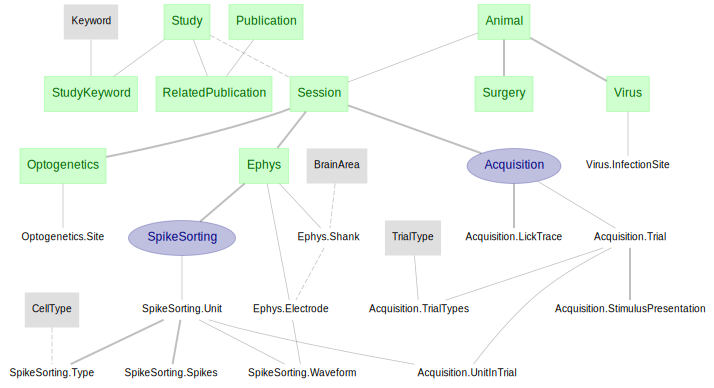

In [14]:
dj.ERD(schema)